# Import packages


In [1]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    balanced_accuracy_score,
    f1_score,
    make_scorer,
    matthews_corrcoef,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC

In [2]:
pd.options.display.max_columns = None

# Helper functions:


In [3]:
def get_label_freq(
    label_array: np.array, label_value: float, normalize: bool = False
) -> Union[int | float]:
    """Calculate the frequency of a label value in a label array.

    Args:
        label_array (np.array): A 1D array of labels.
        label_value (float): The label value to calculate its frequency.
        normalize (bool, optional): Whether to return the ratio instead of the raw count. Defaults to False.

    Returns:
        Union[int, float]: The frequency of the label value. Returns a float if `normalize=True`, otherwise an int.
    """
    label_freq = np.sum(label_array == label_value)

    if normalize:
        array_size = len(label_array)

        return label_freq / array_size

    return label_freq

In [4]:
def auc_pr_score(y_true: np.array, y_proba: np.array) -> float:
    """Calculates the Precision-Recall AUC

    Args:
        y_true (np.array): true labels
        y_proba (np.array): prediced label probabilities

    Returns:
        float: the Area Under Curve for the Precision-Recall
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    auc_pr = auc(recall, precision)
    return auc_pr

# Load the data:


load the training training and test data using the `np.loadtext` method


In [5]:
X_train = np.loadtxt("data/Xtrain.csv")
X_test = np.loadtxt("data/Xtest.csv")
y_train = np.loadtxt("data/Ytrain.csv")

# Question No. 1: Exploring data


## Dataset Overview


### How many examples are in the training set? And in the test set?


In [6]:
print(f"Number of samples in training set: {X_train.shape[0]}")
print(f"Number of samples in testing set: {X_test.shape[0]}")

Number of samples in training set: 3000
Number of samples in testing set: 3000


We can see that the training and testing sets have equal number of examples.


### Within the training data, count the positive and negative examples. What's the distribution like? Does this distribution signify any potential issues in terms of design of the machine learning solution and its evaluation?


As we know, the labels for the training data are stored in the `y_train` variable. Let's first check the distinct values in this array (to verfiy that it has only _positive_ and _negative_ labels).

We can use the `np.unique` function which returns the _distinct_ values in the array:


In [7]:
np.unique(y_train)

array([-1.,  1.])

This verify that the data is binary and has only two labels.

Now, let's count the number of positive and negative labels. To do so we'll use the `get_label_freq` function we defined earlier.


In [8]:
count_negative_samples = get_label_freq(y_train, -1)
count_positive_samples = get_label_freq(y_train, 1)
ratio_negative_examples = get_label_freq(y_train, -1, normalize=True)
ratio_positive_examples = get_label_freq(y_train, 1, normalize=True)

In [9]:
print(f"Number of negative examples: {count_negative_samples}")
print(f"Number of positive examples: {count_positive_samples}")

print(f"Ratio of negative examples: {ratio_negative_examples}")
print(f"Ratio of positive examples: {ratio_positive_examples}")

Number of negative examples: 2689
Number of positive examples: 311
Ratio of negative examples: 0.8963333333333333
Ratio of positive examples: 0.10366666666666667


A picture is worth a thousand words! Let's visualize the distribution of the label too see how does it look like:


Text(0.5, 1.0, 'Distribution of labels')

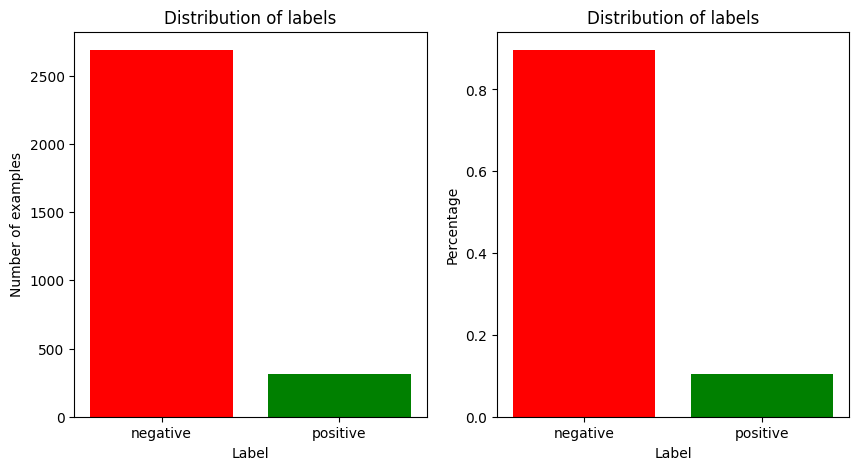

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.bar(
    x=["negative", "positive"],
    height=[count_negative_samples, count_positive_samples],
    color=["red", "green"],
)

ax1.set_xlabel("Label")
ax1.set_ylabel("Number of examples")
ax1.set_title("Distribution of labels")

ax2.bar(
    x=["negative", "positive"],
    height=[ratio_negative_examples, ratio_positive_examples],
    color=["red", "green"],
)

ax2.set_xlabel("Label")
ax2.set_ylabel("Percentage")
ax2.set_title("Distribution of labels")

From the distribution of the labels, we can see that this a clear class-imbalance case. The positive class has about 10% ratio while the negative class has about 90% ratio.

This will affect the choice of evaluation metric. For example, the accuracy metric won't be a good choice.


## Visual Data Exploration


### Pick 10 random objects from each class in the **training** data and display them.


To do this, we'll first select the indices of the positive and negative samples in the training data. Then, we choose from these indices 10 random elements to visualize them.


In [11]:
# select positive and negative labels' indicies using the np.where function
positive_indices = np.where(y_train == 1)[0]
negative_indices = np.where(y_train == -1)[0]

In [12]:
print(positive_indices.shape)
print(negative_indices.shape)

(311,)
(2689,)


In [13]:
# set seed to guarantee same results
np.random.seed(41)

# select 10 random elements from each array
sample_positive_indices = np.random.choice(positive_indices, 10, replace=False)
sample_negative_indices = np.random.choice(negative_indices, 10, replace=False)

Visualize the 10 random positive examples:


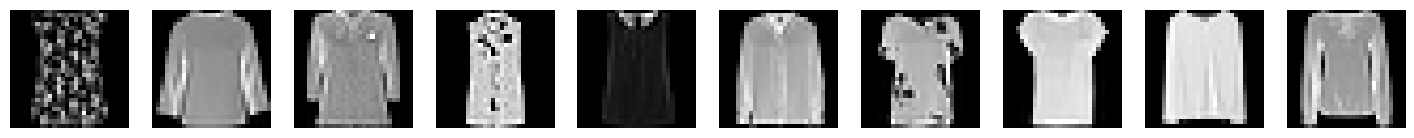

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(18, 10))

for i, idx in enumerate(sample_positive_indices):
    ax[i].matshow(X_train[idx, :].reshape(28, 28), cmap="gray")
    ax[i].axis("off")

plt.show()

We notice that the **positive** examples are image of shirts, T-Shirt, jackets, and dresses.


Visualize the 10 random negative examples:


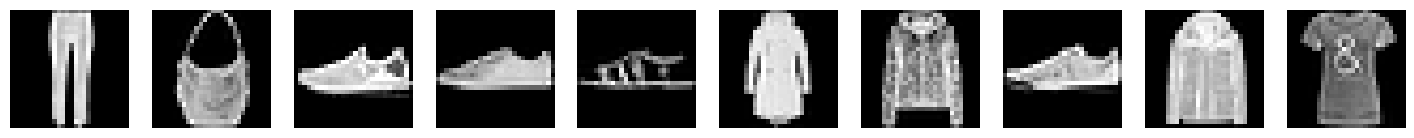

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(18, 10))

for i, idx in enumerate(sample_negative_indices):
    ax[i].matshow(X_train[idx, :].reshape(28, 28), cmap="gray")
    ax[i].axis("off")

plt.show()

The **negative** examples are for shoes/sneakers, bags, trousers, but also contain pullovers and dresses


After inspecting the positive and negative examples, we notice that there is an overlap of images labeled as negative and positive.

The positive examples are generally for tops (shirts, jackets, pullovers) and negative examples are for anything else (trousers, bag, shoes).

However, from the previous plot we saw that negative data contains images of two jackets and one t-shirt. This will make it harder for the classifier to distinguish between positive and negative classes.


### Do the same for 10 random objects from the test set. Are there any peculiarities in the data that might challenge your classifier's ability to generalise?


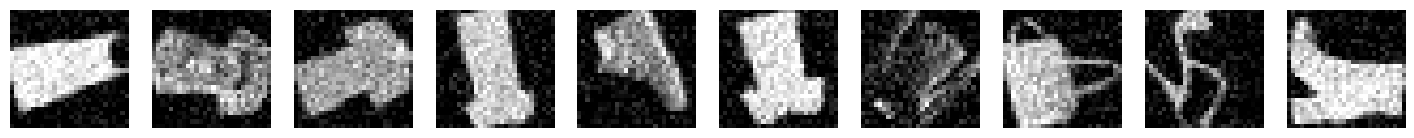

In [16]:
np.random.seed(41)

sample_indices = np.random.choice(np.arange(X_test.shape[0]), size=10, replace=False)

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(18, 14))

for i, idx in enumerate(sample_indices):
    ax[i].matshow(X_test[idx, :].reshape(28, 28), cmap="gray")
    ax[i].axis("off")

plt.show()

The test data seems that it contains images of same objects as training data (shirt, bag, shoe, etc). However, the images are **rotated** and have some **white noise pixels** (possibly salt and pepper noise).

A _googd_ classifier should be able to identify these images even after rotation. The classifier should learn features related to the structure of the object, and it should be rotation-invariant.


## Choosing the Right Metric


### Which performance metric would be best for this task (accuracy, AUC-ROC, AUC-PR, F1, Matthews correlation coefficient, mean squared error etc.)? Share your reasoning for this choice.


As stated before, this is an imbalanced dataset, and therefore, the accuracy metric would be simply misleading. A classifier that always predicts the negative class (-1) would achieve 90% accuracy.

1. AUC-ROC: this metric plots **true positive rate** against **false positive rate** for different classification threshold. This metric doesn't take into account the _false negative_. False negative is the number of examples classified as negative while their actual class is positive. Given that the ratio of positive examples is very small (311 out of 3000) we care very much about accurately identifying these positive examples.

2. Precision-Recall AUC: this metrics computes the area under the precision-recall curve. Recall is the same as true positive rate mentioned in previous metric. Unlike the previous metric, here, precision take the false negative into account. Precision is the ratio of true positive to all positive. Higher precision means classifier is more sure about its prediction.

In this example, given that our dataset is very imbalanced and assuming that we care about identifying the minority class, the Precision-Recall AUC metric would be a better option.

Let's take the following example to show the difference between the two metrics:

Suppose we have two classifiers: **SVM** and **KNN**, and they have the following results:

|     |  SVM |  KNN |
| :-- | ---: | ---: |
| TP  |  250 |  200 |
| FN  |   61 |  111 |
| FP  |  250 |    0 |
| TN  | 2439 | 2689 |

Then **SVM** will have `TPR=0.80` and `FPR=0.09` and **KNN** will have `TPR=0.64` and `FPR=0`

For the Precsion-Recall, **SVM** will have `precision=0.5` and `recall=0.80` and **KNN** will have `precision=1` and `FPR=0.64`


## Benchmarking a Random Classifier


### Imagine a classifier that randomly guesses labels. What accuracy would you expect it to achieve on both the training and test datasets? Show this through a calculation, statistical proof, or a coding experiment.


## Understanding AUC Metrics for Random Classifier


### What would be the AUC-ROC and AUC-PR for a random classifier in this context? Again, support your answer with a mathematical or statistical argument, or a practical demonstration.


# Question No. 2: Nearest Neighbour Classifier


First, let's define each evaluation metric:

1. Accuracy: the accuracy is the simplest metric. It is the ratio of correctly classified samples over all samples.
2. Balanced Accuracy: the sume of **true positive rate (TPR)** and **true negative rate (TNR)** divided by 2. Here, **TPR** is the number of true positive divided by total positive, and **TNR** is the number of true negative divided by total negative.
3. AUC-ROC: area under the receiver operating characteristic curve. The roc curve plots the **true positive rate (TPR)** against **false positive rate (FPR)**.
4. AUC-PR: area under the precision-recall curve. The precision-recall curve plots the **Precision** against **Recall**. Recall is same as true positive rate.
5. F1: harmonic mean of precision and recall.
6. Matthews Correlation Coefficient:


Performing Stratified Cross Validation on the _training_ data.


In [17]:
# 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
# perform 5 folds cross validation on the *training* data and store the metrics in the `folds_results` list

folds_results = []

for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    # build the corresponding training and "validation" data
    X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
    X_test_fold, y_test_fold = X_train[test_index], y_train[test_index]

    # print label percentage for debugging
    print(f"Fold: {fold + 1}")
    print(
        f"Percentage of positive class in training data: {get_label_freq(y_train_fold, 1, True):.2f}"
    )
    print(
        f"Percentage of negative class in training data: {get_label_freq(y_train_fold, -1, True):.2f}"
    )

    print(
        f"Percentage of positive class in validation data: {get_label_freq(y_test_fold, 1, True):.2f}"
    )
    print(
        f"Percentage of negative class in validation data: {get_label_freq(y_test_fold, -1, True):.2f}"
    )

    print("==" * 30)

    # define 5 nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=5)

    # fit the classifier to the training data
    knn.fit(X_train_fold, y_train_fold)

    # get predictions on the validation data
    y_pred_fold = knn.predict(X_test_fold)

    # get prediction probabilities on the validation data
    # for calculating AUC-ROC and AUC-PR metrics
    y_pred_proba_fold = knn.predict_proba(X_test_fold)

    folds_results.append(
        {
            "fold": fold + 1,
            "accuracy": accuracy_score(y_test_fold, y_pred_fold),
            "balanced_accuracy": balanced_accuracy_score(y_test_fold, y_pred_fold),
            "roc_auc": roc_auc_score(y_test_fold, y_pred_proba_fold[:, 1]),
            "pr_auc": auc_pr_score(y_test_fold, y_pred_proba_fold[:, 1]),
            "f1_score": f1_score(y_test_fold, y_pred_fold),
            "matthews_correlation_coefficient": matthews_corrcoef(
                y_test_fold, y_pred_fold
            ),
        }
    )

Fold: 1
Percentage of positive class in training data: 0.10
Percentage of negative class in training data: 0.90
Percentage of positive class in validation data: 0.10
Percentage of negative class in validation data: 0.90
Fold: 2
Percentage of positive class in training data: 0.10
Percentage of negative class in training data: 0.90
Percentage of positive class in validation data: 0.10
Percentage of negative class in validation data: 0.90
Fold: 3
Percentage of positive class in training data: 0.10
Percentage of negative class in training data: 0.90
Percentage of positive class in validation data: 0.10
Percentage of negative class in validation data: 0.90
Fold: 4
Percentage of positive class in training data: 0.10
Percentage of negative class in training data: 0.90
Percentage of positive class in validation data: 0.10
Percentage of negative class in validation data: 0.90
Fold: 5
Percentage of positive class in training data: 0.10
Percentage of negative class in training data: 0.90
Percenta

In [19]:
metrics_df = pd.DataFrame(folds_results)

Let's show the evaluation metrics for each fold:


In [20]:
metrics_df

,fold,accuracy,balanced_accuracy,roc_auc,pr_auc,f1_score,matthews_correlation_coefficient
0,1,0.911667,0.736689,0.859396,0.614730,0.547009,0.499362
1,2,0.908333,0.727695,0.863113,0.555713,0.529915,0.480387
2,3,0.898333,0.665038,0.851181,0.547055,0.429907,0.381459
3,4,0.923333,0.736059,0.888296,0.668925,0.574074,0.540138
4,5,0.906667,0.681653,0.822234,0.492275,0.471698,0.431785


In [21]:
metrics_statistics_df = pd.DataFrame(
    data=[metrics_df.mean(), metrics_df.std()], index=["mean", "standard_deviation"]
).drop(columns=["fold"])

Let's show the variation (mean and standard deviation) of each metric to better understand our results:


In [22]:
metrics_statistics_df

,accuracy,balanced_accuracy,roc_auc,pr_auc,f1_score,matthews_correlation_coefficient
mean,0.909667,0.709427,0.856844,0.575740,0.510520,0.466626
standard_deviation,0.009083,0.033645,0.023796,0.067812,0.058635,0.061507


From the above table we see that, as expected, accuracy is very high and with very small variability among different folds.

Other metrics are relatively high, but not very good. This shows that a KNN classifier can serve as a baseline model.


## Plotting ROC and PR curves:


To plot the ROC and PR curves for one fold, we will utilize the `RocCurveDisplay` and `PrecisionRecallDisplay` classes from sklearn.


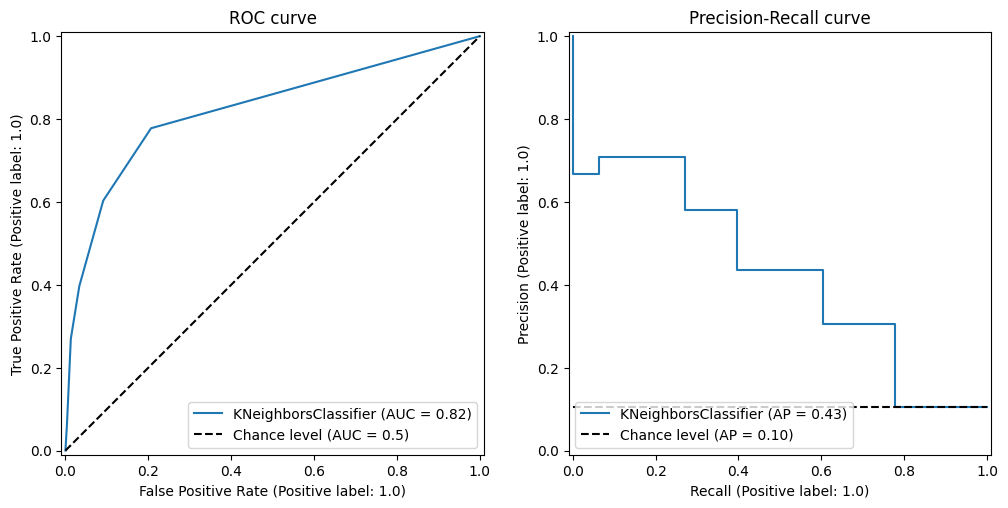

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

RocCurveDisplay.from_estimator(
    estimator=knn, X=X_test_fold, y=y_test_fold, plot_chance_level=True, ax=ax1
)

PrecisionRecallDisplay.from_estimator(
    estimator=knn, X=X_test_fold, y=y_test_fold, plot_chance_level=True, ax=ax2
)

ax1.set_title("ROC curve")
ax2.set_title("Precision-Recall curve")

plt.show()

For the ROC curve, we want the curve to be as close as possible to the upper left corner (0 on x-axis and 1 on y-axis). This point is the ideal point where the classifier has perfect true positive rate equal to 1 and false positive rate equal to 0.

The KNN classifier has a good threshold where true positive rate is equal (or close) to `0.8` and false positive rate is equal (or close) to `0.2`. Beyond this point the classifier becomes more _steep_ towards higher values of false positive rate.

We can also see that the curve is above the random classifier curve and it has AUC = 0.82.


For the PR curve, we notice that precision immediately drops to 0.7 for recall = 0.1.

The precision becomes very low for recall = 0.6

A good classifier should have relatively high precision (0.8-1) for high recall values (0.8-1).

In other words, we can say that for our KNN classifier, once it starts to retrieve more positive classes, its prediction accuracy degrades. That is the number of false positive becomes higher.


To further aid our understanding of the model performance, we show the confusion matrix which shows the different type of errors:


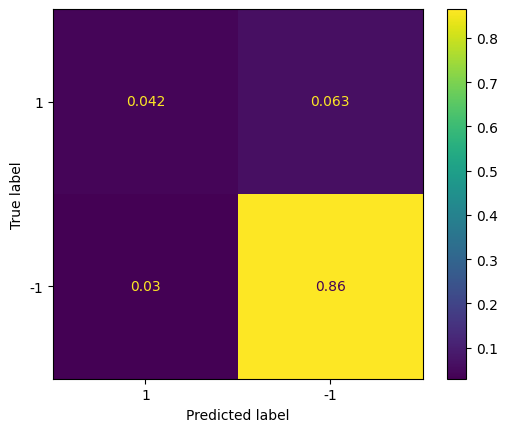

In [24]:
ConfusionMatrixDisplay.from_estimator(
    estimator=knn, X=X_test_fold, y=y_test_fold, labels=[1, -1], normalize="all"
)

## Studying the effect of different pre-processing approaches:


To understand how different pre-processing techniques affect the classification performance, we need to repeatedly apply a pre-processing technique then perform cross validation and calculate the mean values for our evaluation metrics.

Luckily, we can use `GridSearchCV` and treat the pre-processing method as a hyperparameter that we're interested in finding the best value for.

To do this, we use `Pipeline`. `Pipeline` is a way to encapsulate several pre-processing stpes with a classifier into one single object. Here, our pipeline consists of simply two steps:

1. `preprocessor`: the pre-processing function to apply on the data.
2. `classifier`: the KNN classifier.

We search for different possible values for the `preprocesser` _hyperparameter_.


In [25]:
# define a pipeline object
# first step is pre-processing the data
# second step is classification
pipeline = Pipeline(
    [
        ("preprocessor", StandardScaler(with_mean=False, with_std=False)),
        ("classifier", KNeighborsClassifier(n_neighbors=5)),
    ]
)

In [26]:
# the param_grid tells the grid search what parameters to search for
# here, we are interested in the different approaches for pre-processing
param_grid = [
    {
        "preprocessor": [
            StandardScaler(with_mean=True, with_std=True),
            StandardScaler(with_mean=True, with_std=False),
            StandardScaler(with_mean=False, with_std=True),
            StandardScaler(
                with_mean=False, with_std=False
            ),  # effectively no pre-processing
            MinMaxScaler(),
            MaxAbsScaler(),
            Normalizer(norm="l1"),
            Normalizer(norm="l2"),
        ],
    }
]

In [27]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring={
        "accuracy": make_scorer(accuracy_score),
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "roc_auc": make_scorer(roc_auc_score, response_method="predict_proba"),
        "pr_auc": make_scorer(auc_pr_score, response_method="predict_proba"),
        "f1_score": make_scorer(f1_score),
        "matthews_correlation_coefficient": make_scorer(matthews_corrcoef),
    },
    refit=False,
    verbose=1,
)

In [28]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        StandardScaler(with_mean=False,
                                                       with_std=False)),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'preprocessor': [StandardScaler(),
                                           StandardScaler(with_std=False),
                                           StandardScaler(with_mean=False),
                                           StandardScaler(with_mean=False,
                                                          with_std=False),
                                           MinMaxScaler(), MaxAbsScaler(),
                                           Normalizer(norm=...
                      'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                      'f1_score': make_scorer(f1_score, response_method='predict'),
                      'matthews_correlation_coefficient': make_scorer(matthews_corrcoef, response_method='predict'),
                      'pr_auc': make_scorer(auc_pr_score, response_method='predict_proba'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')},
             verbose=1)

In [29]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)

In [30]:
grid_search_results_plot = (
    grid_search_results[
        [
            "mean_test_accuracy",
            "mean_test_balanced_accuracy",
            "mean_test_roc_auc",
            "mean_test_pr_auc",
            "mean_test_f1_score",
            "mean_test_matthews_correlation_coefficient",
        ]
    ]
    .set_index(grid_search_results["param_preprocessor"].astype("str"))
    .sort_values(by="mean_test_pr_auc", ascending=False)
)

[Text(0.5, 0, 'mean_test_accuracy'),
 Text(1.5, 0, 'mean_test_balanced_accuracy'),
 Text(2.5, 0, 'mean_test_roc_auc'),
 Text(3.5, 0, 'mean_test_pr_auc'),
 Text(4.5, 0, 'mean_test_f1_score'),
 Text(5.5, 0, 'mean_test_matthews_correlation_coefficient')]

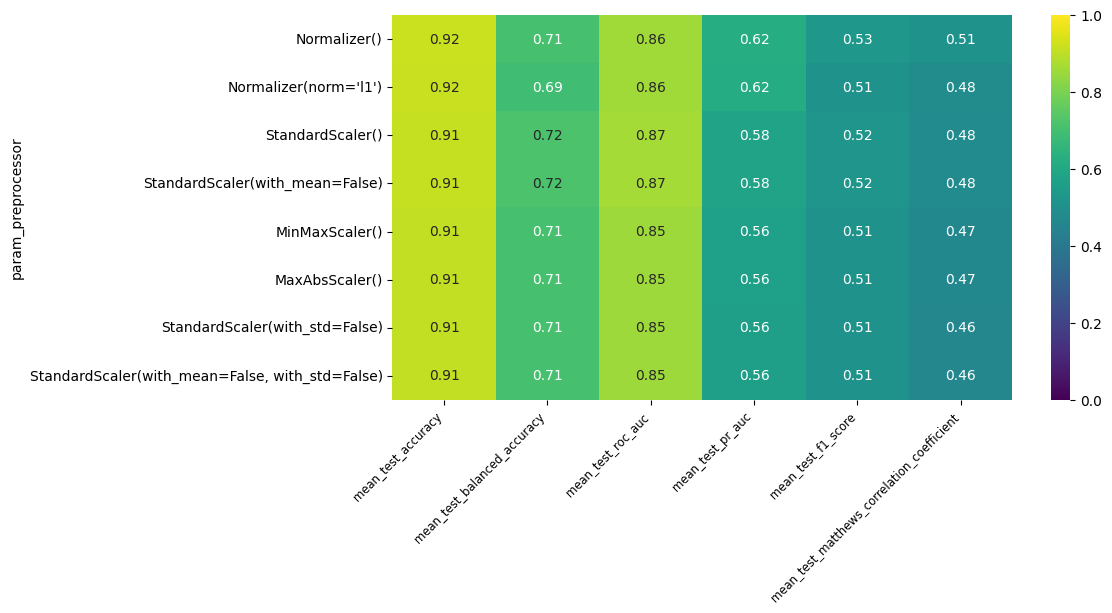

In [31]:
plt.figure(figsize=(10, 5))

chart = sns.heatmap(
    data=grid_search_results_plot,
    vmin=0,
    vmax=1,
    annot=True,
    cmap="viridis",
)

chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment="right",
    fontweight="light",
    fontsize="small",
)

We quickly see that applying the `Normalizer` improve the results of AUC-PC.

Also, `StandardScaler` delivers performance improvement.

Basically, both of these approaches re-scales the images values to smaller range (0-1). This rescaling makes the algorithm more robust and reduces the effect of bigger values in the image intensities.

KNN algorithm calculate the distance for each sample between its _k_ neighbors. This distance calculation is very much influenced by the values of the feature vecotrs. Scaling ensures that features are on the same range and contribute equally to the distance.


Let's plot the results of normalization and scaling to understand their impacts on images:


In [32]:
normalizer = Normalizer()
scaler = StandardScaler()

In [33]:
X_train_normalized = normalizer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train)

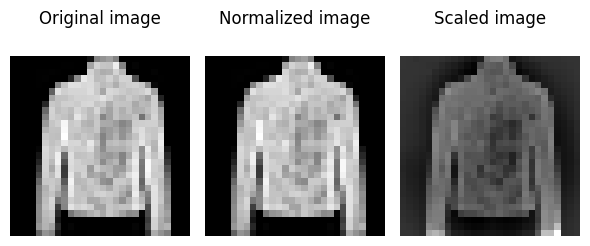

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 12))


ax[0].matshow(X_train[0, :].reshape(28, 28), cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original image")

ax[1].matshow(X_train_normalized[0, :].reshape(28, 28), cmap="gray")
ax[1].axis("off")
ax[1].set_title("Normalized image")

ax[2].matshow(X_train_scaled[0, :].reshape(28, 28), cmap="gray")
ax[2].axis("off")
ax[2].set_title("Scaled image")

plt.tight_layout()
plt.show()

# Question No. 3: Cross-validation of SVM and RFs


In this section, we'll study the performance of SVM and Random Forests classifiers.

Each of these classifiers has its own _hyperparameters_. In addition, SVM has a `decision_function` for calculating prediction probabilities while Random Forest must use the `predict_proba` function. We distinguish between the two by specifying evaluation metrics for each classifier separately.

Lastly, we need to also study the impact of any pre-processing method before fitting a classifier. Therefore, we (again) utilize a pipeline consisting of two steps: `preprocessor` and `classifier`.

Our goal is to tune the possible hyperparameters of this pipeline and report the different evaluation metrics to find the set of best performing classifiers.

1. Pre-processing: for pre-processing we have three options: `StandardScaler`, `MinMaxScaler`, and `Normalizer`.
2. SVM: for svm, we have three different types of kernels (`linear`, `poly`, and `rbf`). For each kernel type, there is a set of hyperparameters. The best way to tune SVM is to define three `param_grid`s, one for each kernel. Each `param_grid` has a set of hyperparameters for the corresponding kernel type (degree for `poly` kernel, `gamma` for `poly` and `rbf`, and so on).
3. Random Forests: the random forest has only two important hyperparameters: `n_estimators`, `max_depth`.


Given that each classifier has a different set of hyperparameters, we'll define two `Pipeline` object and perform tuning on each one, and eventually compare the results of best performing classifiers for both SVM and Random Forests.

We'll consider the Precision-Recall AUC the metric to compare different classifiers.


In [35]:
svm_pipeline = Pipeline(
    [
        ("preprocessor", StandardScaler()),
        ("classifier", SVC()),
    ]
)

In [36]:
rf_pipeline = Pipeline(
    [
        ("preprocessor", StandardScaler()),
        ("classifier", RandomForestClassifier()),
    ]
)

In [37]:
# define parameter grid for SVM
# a list of three dictionaries
# each dictionary correspond to a kernel type
svm_param_grid = [
    # linear kernel
    {
        "preprocessor": [
            StandardScaler(),
            MinMaxScaler(),
            Normalizer(),
        ],
        "classifier": [SVC(kernel="linear")],
        "classifier__C": [0.1, 1, 10, 100],
    },
    # poly kernel
    {
        "preprocessor": [
            StandardScaler(),
            MinMaxScaler(),
            Normalizer(),
        ],
        "classifier": [SVC(kernel="poly")],
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__degree": [3, 5],
        "classifier__gamma": [0.01, 0.1, 1, 10, 100],
    },
    # rbf kernel
    {
        "preprocessor": [
            StandardScaler(),
            MinMaxScaler(),
            Normalizer(),
        ],
        "classifier": [SVC(kernel="rbf")],
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__gamma": [0.01, 0.1, 1, 10, 100],
    },
]

In [38]:
# define parameter grid for Random Forests
rf_param_grid = {
    "preprocessor": [
        StandardScaler(),
        MinMaxScaler(),
        Normalizer(),
    ],
    "classifier": [RandomForestClassifier()],
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [10, 20, None],
}

In [39]:
# scoring function in SVM use the `decision_function` for calculating AUC metrics
svm_scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, response_method="decision_function"),
    "pr_auc": make_scorer(auc_pr_score, response_method="decision_function"),
}

In [40]:
# # scoring function in Random Forest use the `predict_proba` for calculating AUC metrics
rf_scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, response_method="predict_proba"),
    "pr_auc": make_scorer(auc_pr_score, response_method="predict_proba"),
}

In [41]:
# define a 5-fold cross validation grid search object for SVM
svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring=svm_scoring,
    n_jobs=-1,
    refit=False,
    verbose=1,
)

In [42]:
# define a 5-fold cross validation grid search object for Random Forests
rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring=rf_scoring,
    n_jobs=-1,
    refit=False,
    verbose=1,
)

In [43]:
svm_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid=[{'classifier': [SVC(kernel='linear')],
                          'classifier__C': [0.1, 1, 10, 100],
                          'preprocessor': [StandardScaler(), MinMaxScaler(),
                                           Normalizer()]},
                         {'classifier': [SVC(kernel='poly')],
                          'classifier__C': [0.1, 1, 10, 100],
                          'classifier__degree': [3, 5],
                          'cl...
                          'preprocessor': [StandardScaler(), MinMaxScaler(),
                                           Normalizer()]}],
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                      'pr_auc': make_scorer(auc_pr_score, response_method='decision_function'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='decision_function')},
             verbose=1)

In [44]:
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier': [RandomForestClassifier()],
                         'classifier__max_depth': [10, 20, None],
                         'classifier__n_estimators': [50, 100, 200],
                         'preprocessor': [StandardScaler(), MinMaxScaler(),
                                          Normalizer()]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                      'pr_auc': make_scorer(auc_pr_score, response_method='predict_proba'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')},
             verbose=1)

After tuning the hyperparameters for each classifier, we want to compare their results and see which combination of parameters delivers the best performance.

However, the number of classifiers created by the grid search is very large.

Let's first build a `DataFrame` for the cross validation results for each classifier:


In [45]:
# convert `cv_results_` dictionary into DataFrame
svm_grid_search_results = pd.DataFrame(svm_grid_search.cv_results_).loc[
    :,
    [
        "param_classifier",
        "param_classifier__C",
        "param_preprocessor",
        "param_classifier__degree",
        "param_classifier__gamma",
        "mean_test_accuracy",
        "mean_test_balanced_accuracy",
        "mean_test_roc_auc",
        "mean_test_pr_auc",
        "mean_fit_time",
    ],
]

# convert the `param_classifier` to string
svm_grid_search_results["param_classifier"] = svm_grid_search_results[
    "param_classifier"
].astype(str)

svm_grid_search_results["param_preprocessor"] = svm_grid_search_results[
    "param_preprocessor"
].astype(str)

In [46]:
# convert `cv_results_` dictionary into DataFrame
rf_grid_search_results = pd.DataFrame(rf_grid_search.cv_results_).loc[
    :,
    [
        "param_classifier",
        "param_classifier__max_depth",
        "param_classifier__n_estimators",
        "param_preprocessor",
        "mean_test_accuracy",
        "mean_test_balanced_accuracy",
        "mean_test_roc_auc",
        "mean_test_pr_auc",
        "mean_fit_time",
    ],
]

# convert the `param_classifier` to string
rf_grid_search_results["param_classifier"] = rf_grid_search_results[
    "param_classifier"
].astype(str)

rf_grid_search_results["param_preprocessor"] = rf_grid_search_results[
    "param_preprocessor"
].astype(str)

Now, let's print the number of different classifiers created by the GridSearch in the two cases:


In [47]:
print(
    f"Number of different classifiers created for SVM: {len(svm_grid_search_results)}"
)
print(
    f"Number of different classifiers created for Random Forests: {len(rf_grid_search_results)}"
)

Number of different classifiers created for SVM: 192
Number of different classifiers created for Random Forests: 27


We have a total of `219` different classifier. This is not feasible to compare.

To remedy this, we chose top 3 performing classifiers for SVM and Random Forests.


In [48]:
# select top 3 performing classifiers for each SVM kernel
# in total, we'll get 9 (because we have three kernels)
svm_top_results = (
    # assign new column rank based on the `mean_test_pr_auc` for each group
    svm_grid_search_results.assign(
        rank=svm_grid_search_results.groupby(by="param_classifier")[
            "mean_test_pr_auc"
        ].rank(method="first", ascending=False)
    )
    # select only top 3 for each kernel
    .pipe(lambda input_df: input_df.loc[input_df["rank"] <= 3])
    # sort results by kernel type and mean_test_pr_auc
    .sort_values(by=["param_classifier", "mean_test_pr_auc"])
    .drop(columns=["rank"])
    .reset_index(drop=True)
)

In [49]:
rf_top_results = rf_grid_search_results.sort_values(
    by="mean_test_pr_auc", ascending=False
).head(3)

In [50]:
svm_top_results

,param_classifier,param_classifier__C,param_preprocessor,param_classifier__degree,param_classifier__gamma,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_roc_auc,mean_test_pr_auc,mean_fit_time
0,SVC(),10.0,Normalizer(),NaN,1.00,0.929333,0.740323,0.932334,0.720952,3.042113
1,SVC(),10.0,MinMaxScaler(),NaN,0.01,0.933667,0.774032,0.927140,0.722559,2.778615
2,SVC(),100.0,MinMaxScaler(),NaN,0.01,0.932667,0.789120,0.929382,0.723279,2.764073
3,SVC(kernel='linear'),0.1,MinMaxScaler(),NaN,NaN,0.921000,0.715799,0.907705,0.607244,3.306184
4,SVC(kernel='linear'),1.0,Normalizer(),NaN,NaN,0.898000,0.509466,0.897837,0.607648,2.981910
5,SVC(kernel='linear'),10.0,Normalizer(),NaN,NaN,0.924667,0.703627,0.909746,0.643214,2.840130
6,SVC(kernel='poly'),0.1,Normalizer(),5.0,100.00,0.935333,0.789230,0.923204,0.724472,3.262249
7,SVC(kernel='poly'),1.0,Normalizer(),5.0,100.00,0.935333,0.789230,0.923204,0.724472,3.448465
8,SVC(kernel='poly'),10.0,Normalizer(),5.0,1.00,0.934333,0.778761,0.927341,0.730973,3.498859


In [51]:
rf_top_results

,param_classifier,param_classifier__max_depth,param_classifier__n_estimators,param_preprocessor,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_roc_auc,mean_test_pr_auc,mean_fit_time
8,RandomForestClassifier(),10.0,200,Normalizer(),0.922333,0.638342,0.940790,0.726483,8.295508
17,RandomForestClassifier(),20.0,200,Normalizer(),0.923333,0.643155,0.936747,0.722427,8.715767
26,RandomForestClassifier(),NaN,200,Normalizer(),0.923333,0.643155,0.938407,0.722302,6.667281


We can quickly see that noth classifiers delivers similar results.

1. SVM with polynomial kernel and `C=10` and `degree=5` and `gamma=1` and Normalizer as pre-processing delivers `0.730973` PR-AUC.
2. Random Forest with `n_estimator=200` and Normalizer as pre-processing delivers `0.733637` PR-AUC.

But we can also see how they differ in their run-time. The random forest classifier needs additional two seconds for running.


The above tables are very rich in information because we can ask different questions and what is considred as a _good_ classifier?

We can see, for example, that linear SVM generally performs badly in comparison with its counterparts. This strongly reinforce the idea that it's hard to separate the data linearlly, and we need some sort of _non-linearlity_ to achieve good performance.

We can also see that RBF kernel runs fatser with a `1%` drop in performance. This could also be of interest for us because classifier running-time is proportional to the dataset size, and once it becomes very big it might not be feasible to run certain classifiers.


To further understand these tables, we'll plot the grid search results to see them visually.


## SVM - Linear Kernel


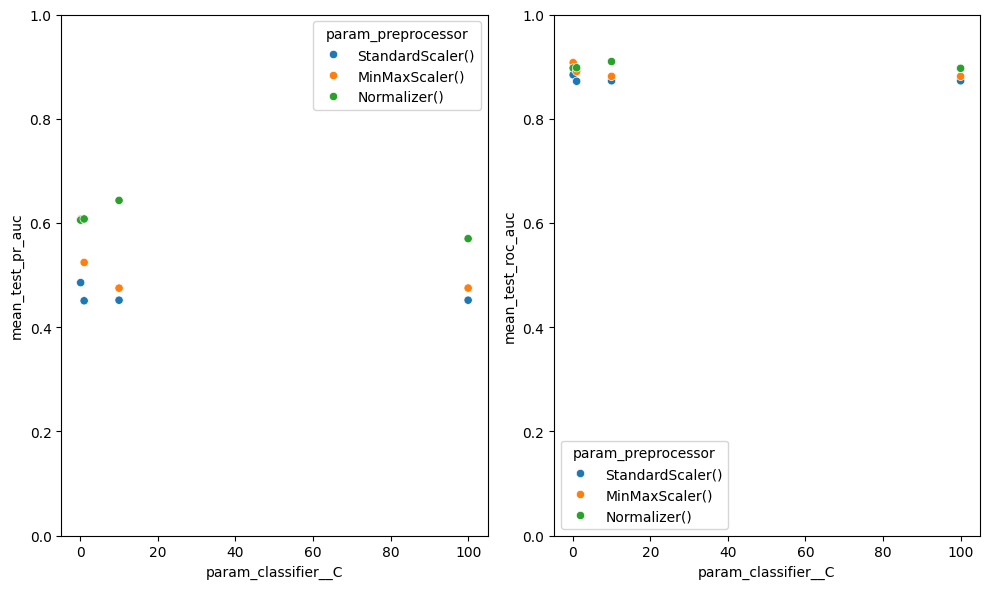

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.scatterplot(
    data=svm_grid_search_results[
        svm_grid_search_results["param_classifier"] == "SVC(kernel='linear')"
    ],
    x="param_classifier__C",
    y="mean_test_pr_auc",
    hue="param_preprocessor",
    ax=ax1,
)

sns.scatterplot(
    data=svm_grid_search_results[
        svm_grid_search_results["param_classifier"] == "SVC(kernel='linear')"
    ],
    x="param_classifier__C",
    y="mean_test_roc_auc",
    hue="param_preprocessor",
    ax=ax2,
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## SVM - Polynomial Kernel


Here we will visualize the grid search results for Polynomial SVM using `Normalizer` as pre-processing:


In [53]:
degree_3_scores = svm_grid_search_results.loc[
    (svm_grid_search_results["param_classifier"] == "SVC(kernel='poly')")
    & (svm_grid_search_results["param_classifier__degree"] == 3)
    & (svm_grid_search_results["param_preprocessor"] == "Normalizer()"),
    ["param_classifier__C", "param_classifier__gamma", "mean_test_pr_auc"],
].pivot(
    index="param_classifier__C",
    columns="param_classifier__gamma",
    values="mean_test_pr_auc",
)

degree_5_scores = svm_grid_search_results.loc[
    (svm_grid_search_results["param_classifier"] == "SVC(kernel='poly')")
    & (svm_grid_search_results["param_classifier__degree"] == 5)
    & (svm_grid_search_results["param_preprocessor"] == "Normalizer()"),
    ["param_classifier__C", "param_classifier__gamma", "mean_test_pr_auc"],
].pivot(
    index="param_classifier__C",
    columns="param_classifier__gamma",
    values="mean_test_pr_auc",
)

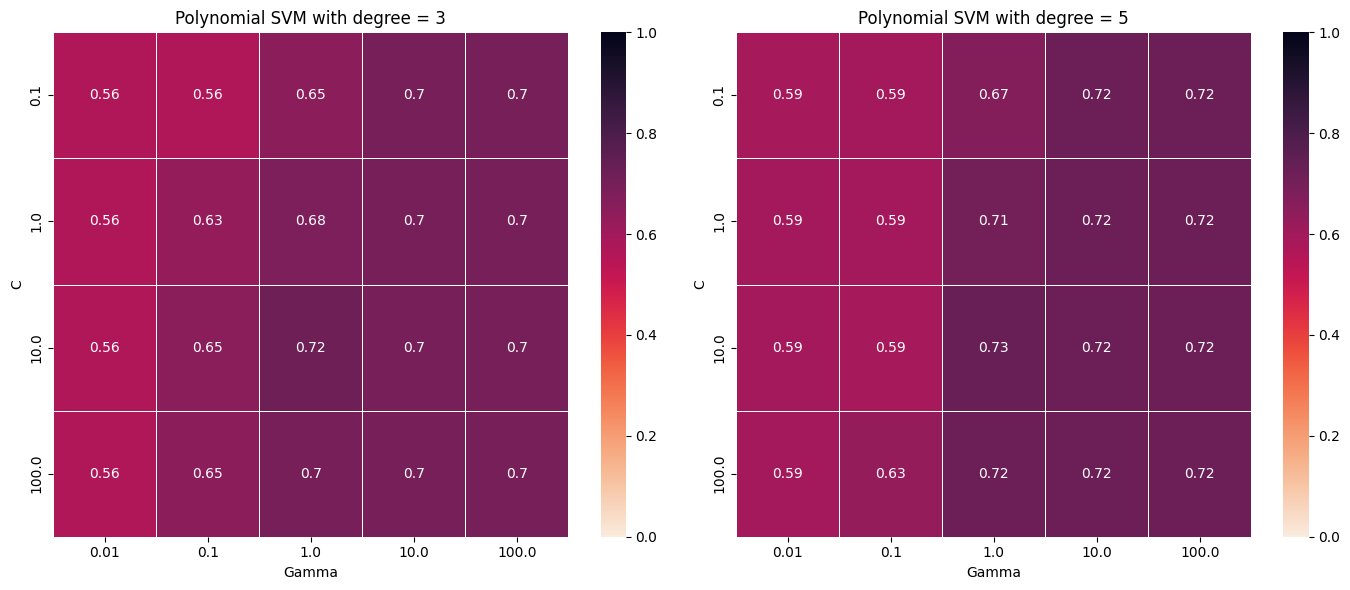

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.heatmap(
    data=degree_3_scores,
    annot=True,
    cmap="rocket_r",
    vmin=0,
    vmax=1,
    ax=ax1,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax1.set_xlabel("Gamma")
ax1.set_ylabel("C")
ax1.set_title("Polynomial SVM with degree = 3")

sns.heatmap(
    data=degree_5_scores,
    annot=True,
    cmap="rocket_r",
    vmin=0,
    vmax=1,
    ax=ax2,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax2.set_xlabel("Gamma")
ax2.set_ylabel("C")
ax2.set_title("Polynomial SVM with degree = 5")

plt.tight_layout()

plt.show()

This side-by-side plot of the relation between `C` and `gamma` (for two different degrees) tells us that the results of these parameters are stable. We don't see any fluctuations in the `mean_test_pr_auc` metric.

The increase of `gamma` value is related to increase in the PR-AUC score.


## SVM - RBF Kernel


In [55]:
std_scaler_scores = svm_grid_search_results.loc[
    (svm_grid_search_results["param_classifier"] == "SVC()")
    & (svm_grid_search_results["param_preprocessor"] == "StandardScaler()"),
    ["param_classifier__C", "param_classifier__gamma", "mean_test_pr_auc"],
].pivot(
    index="param_classifier__C",
    columns="param_classifier__gamma",
    values="mean_test_pr_auc",
)

In [56]:
mx_scaler_scores = svm_grid_search_results.loc[
    (svm_grid_search_results["param_classifier"] == "SVC()")
    & (svm_grid_search_results["param_preprocessor"] == "MinMaxScaler()"),
    ["param_classifier__C", "param_classifier__gamma", "mean_test_pr_auc"],
].pivot(
    index="param_classifier__C",
    columns="param_classifier__gamma",
    values="mean_test_pr_auc",
)

In [57]:
normalizer_scores = svm_grid_search_results.loc[
    (svm_grid_search_results["param_classifier"] == "SVC()")
    & (svm_grid_search_results["param_preprocessor"] == "Normalizer()"),
    ["param_classifier__C", "param_classifier__gamma", "mean_test_pr_auc"],
].pivot(
    index="param_classifier__C",
    columns="param_classifier__gamma",
    values="mean_test_pr_auc",
)

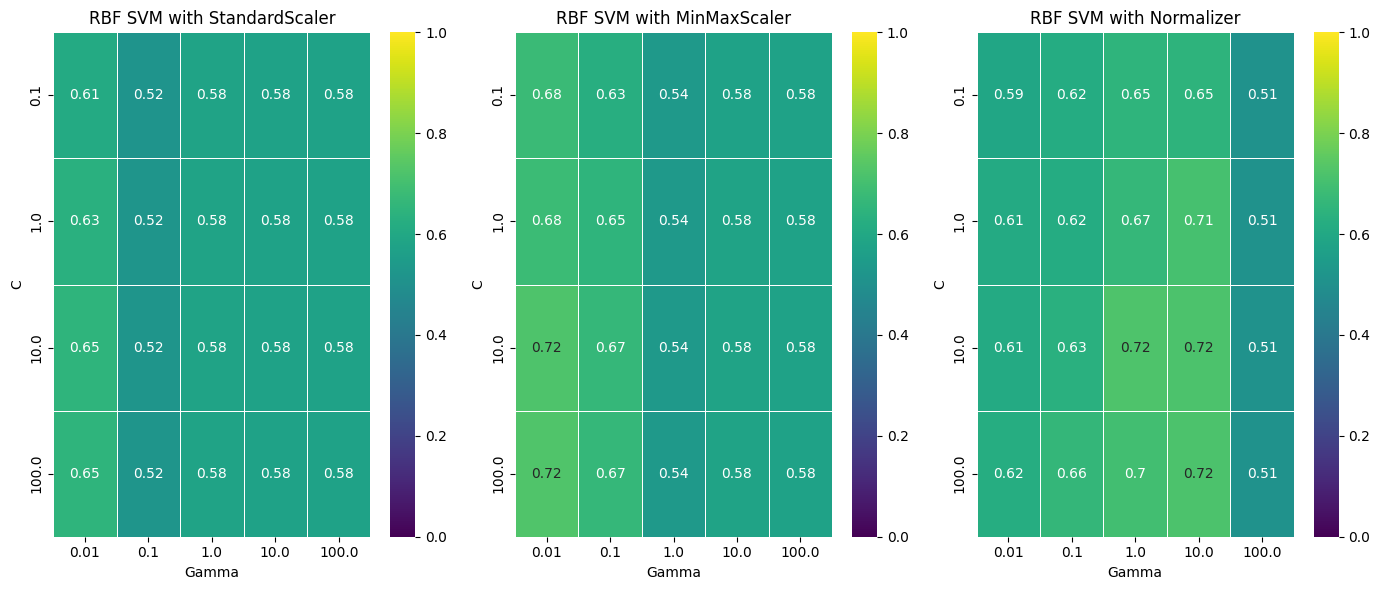

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

sns.heatmap(
    data=std_scaler_scores,
    annot=True,
    cmap="viridis",
    vmin=0,
    vmax=1,
    ax=ax1,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax1.set_xlabel("Gamma")
ax1.set_ylabel("C")
ax1.set_title("RBF SVM with StandardScaler")

sns.heatmap(
    data=mx_scaler_scores,
    annot=True,
    cmap="viridis",
    vmin=0,
    vmax=1,
    ax=ax2,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax2.set_xlabel("Gamma")
ax2.set_ylabel("C")
ax2.set_title("RBF SVM with MinMaxScaler")

sns.heatmap(
    data=normalizer_scores,
    annot=True,
    cmap="viridis",
    vmin=0,
    vmax=1,
    ax=ax3,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax3.set_xlabel("Gamma")
ax3.set_ylabel("C")
ax3.set_title("RBF SVM with Normalizer")

plt.tight_layout()

plt.show()

## Random Forests


In [59]:
rf_std_scaler_scores = rf_grid_search_results.loc[
    (rf_grid_search_results["param_preprocessor"] == "StandardScaler()"),
].pivot(
    index="param_classifier__max_depth",
    columns="param_classifier__n_estimators",
    values="mean_test_pr_auc",
)

rf_mx_scaler_scores = rf_grid_search_results.loc[
    (rf_grid_search_results["param_preprocessor"] == "MinMaxScaler()"),
].pivot(
    index="param_classifier__max_depth",
    columns="param_classifier__n_estimators",
    values="mean_test_pr_auc",
)

rf_normalizer_scores = rf_grid_search_results.loc[
    (rf_grid_search_results["param_preprocessor"] == "Normalizer()"),
].pivot(
    index="param_classifier__max_depth",
    columns="param_classifier__n_estimators",
    values="mean_test_pr_auc",
)

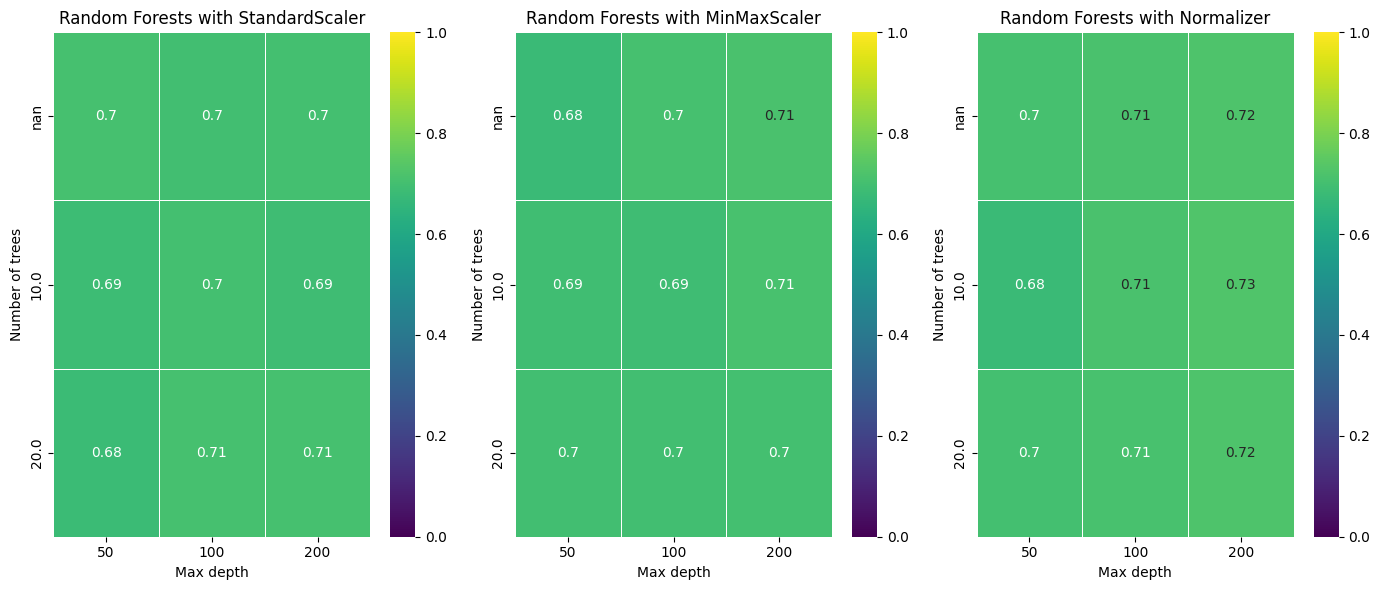

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

sns.heatmap(
    data=rf_std_scaler_scores,
    annot=True,
    cmap="viridis",
    vmin=0,
    vmax=1,
    ax=ax1,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax1.set_xlabel("Max depth")
ax1.set_ylabel("Number of trees")
ax1.set_title("Random Forests with StandardScaler")

sns.heatmap(
    data=rf_mx_scaler_scores,
    annot=True,
    cmap="viridis",
    vmin=0,
    vmax=1,
    ax=ax2,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax2.set_xlabel("Max depth")
ax2.set_ylabel("Number of trees")
ax2.set_title("Random Forests with MinMaxScaler")

sns.heatmap(
    data=rf_normalizer_scores,
    annot=True,
    cmap="viridis",
    vmin=0,
    vmax=1,
    ax=ax3,
    linewidths=0.5,
    cbar_kws={"shrink": 1},
    annot_kws={"size": 10},
)
ax3.set_xlabel("Max depth")
ax3.set_ylabel("Number of trees")
ax3.set_title("Random Forests with Normalizer")

plt.tight_layout()

plt.show()

## ROC and Precision-Recall curves


In [61]:
top_performing_svm_pipelines = [
    # RBF SVM
    ("RBF_SVM_Normalizer_C_10_gamma_1", Normalizer(), SVC(kernel="rbf", C=10, gamma=1)),
    (
        "RBF_SVM_MinMaxScaler_C_10_gamma_0.01",
        MinMaxScaler(),
        SVC(kernel="rbf", C=10, gamma=0.01),
    ),
    (
        "RBF_SVM_MinMaxScaler_C_100_gamma_0.01",
        MinMaxScaler(),
        SVC(kernel="rbf", C=100, gamma=0.01),
    ),
    # linear SVM
    ("Linear_SVM_MinMaxScaler_C_0.1", MinMaxScaler(), SVC(kernel="linear", C=0.1)),
    ("Linear_SVM_Normalizer_C_1", Normalizer(), SVC(kernel="linear", C=1)),
    ("Linear_SVM_Normalizer_C_10", Normalizer(), SVC(kernel="linear", C=10)),
    # polynomial SVM
    (
        "Polynomial_SVM_Normalizer_C_0.1_degree_5_gamma_100",
        Normalizer(),
        SVC(kernel="poly", C=0.1, degree=5, gamma=100),
    ),
    (
        "Polynomial_SVM_Normalizer_C_1_degree_5_gamma_100",
        Normalizer(),
        SVC(kernel="poly", C=1, degree=5, gamma=100),
    ),
    (
        "Polynomial_SVM_Normalizer_C_10_degree_5_gamma_1",
        Normalizer(),
        SVC(kernel="poly", C=10, degree=5, gamma=1),
    ),
]

In [62]:
top_performing_rf_pipelines = [
    # Random Forests
    (
        "rf_Normalizer_depth_None_n_trees_200",
        Normalizer(),
        RandomForestClassifier(
            max_depth=None,
            n_estimators=200,
        ),
    ),
    (
        "rf_Normalizer_depth_20_n_trees_200",
        Normalizer(),
        RandomForestClassifier(
            max_depth=20,
            n_estimators=200,
        ),
    ),
    (
        "rf_Normalizer_depth_10_n_trees_200",
        Normalizer(),
        RandomForestClassifier(
            max_depth=10,
            n_estimators=200,
        ),
    ),
]

In [63]:
results = {}

for (
    svm_pipeline_name,
    pipe_preprocessor,
    pipe_classifier,
) in top_performing_svm_pipelines:

    X_train_fold, X_test_fold, y_train_fold, y_test_fold = train_test_split(
        X_train, y_train, test_size=0.33, random_state=42, stratify=y_train
    )

    svm_pipeline = Pipeline(
        steps=[("preproessor", pipe_preprocessor), ("classifier", pipe_classifier)]
    )

    svm_pipeline.fit(X_train_fold, y_train_fold)

    y_pred_proba_fold = svm_pipeline.decision_function(X_test_fold)

    results.update(
        {svm_pipeline_name: {"y_true": y_test_fold, "y_score": y_pred_proba_fold}}
    )


for (
    rf_pipeline_name,
    pipe_preprocessor,
    pipe_classifier,
) in top_performing_rf_pipelines:

    X_train_fold, X_test_fold, y_train_fold, y_test_fold = train_test_split(
        X_train, y_train, test_size=0.33, random_state=42, stratify=y_train
    )

    rf_pipeline = Pipeline(
        steps=[("preproessor", pipe_preprocessor), ("classifier", pipe_classifier)]
    )

    rf_pipeline.fit(X_train_fold, y_train_fold)

    y_pred_proba_fold = rf_pipeline.predict_proba(X_test_fold)

    results.update(
        {rf_pipeline_name: {"y_true": y_test_fold, "y_score": y_pred_proba_fold[:, 1]}}
    )

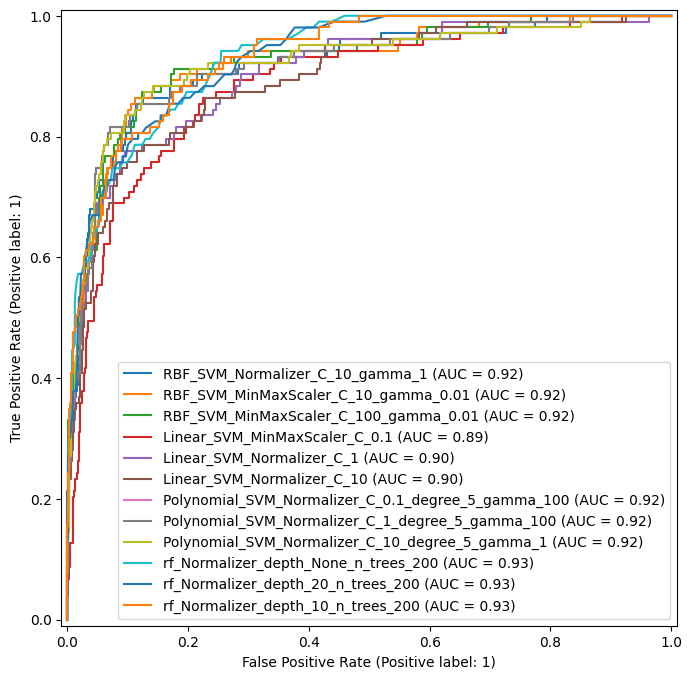

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

for svm_pipeline_name in results.keys():
    y_true = results[svm_pipeline_name].get("y_true")
    y_score = results[svm_pipeline_name].get("y_score")

    RocCurveDisplay.from_predictions(y_true, y_score, name=svm_pipeline_name, ax=ax)

plt.show()

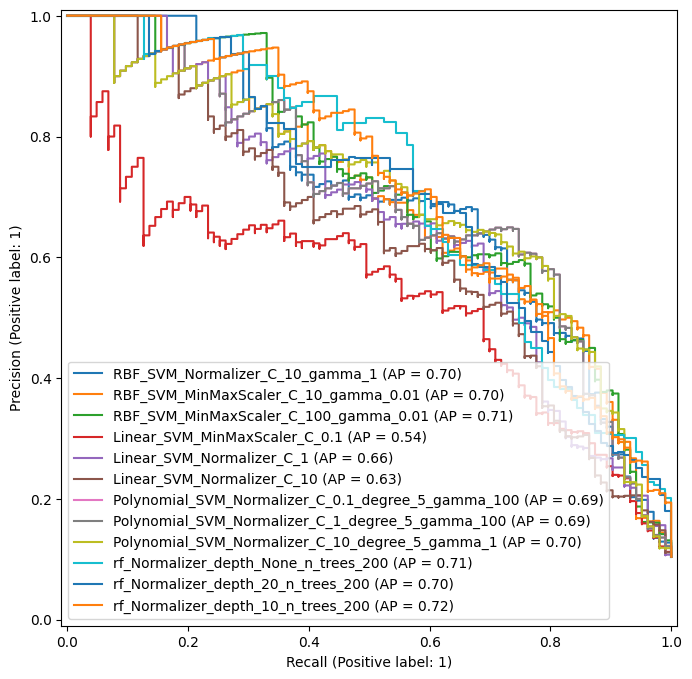

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

for svm_pipeline_name in results.keys():
    y_true = results[svm_pipeline_name].get("y_true")
    y_score = results[svm_pipeline_name].get("y_score")

    PrecisionRecallDisplay.from_predictions(
        y_true, y_score, name=svm_pipeline_name, ax=ax
    )

plt.show()

Key observations from the previous two plots:

1. Almost ROC curves are good with curve very close to the uper left corner. The random forest classifiers perform extremely well with AUC of 0.93, and RBF SVM also has similar performance. However, linear SVM tends to have lower performance.

2. For the Precision Recall curve, we see that the linear SVM performs very badly with AUC of 0.54. This shows how ROC alone is not enough. The random forests classifier and RBF SVM perform generally good but it's clear how the classifiers suffer to maintain good precision after recall of 0.6


# Question No. 4 PCA:


## Reduce the number of dimensions of the training data using PCA to 2 and plot a scatter plot of the training data showing examples of each class in a different colour. What are your observations about the data based on this plot?


We'll perform PCA on original data and scaled data to see if scaling features affect the results of PCA:


In [66]:
# define a StandardScaler which convert the distribution to zero mean and unit variance
scaler = StandardScaler()

In [67]:
scaled_X_train = scaler.fit_transform(X_train)

Verify scaled data has zero mean and unit variance:


In [68]:
print(f"Mean after scaling: {scaled_X_train.mean(axis=0).round()[0]}")
print(f"Standard deviation after scaling: {scaled_X_train.std(axis=0).round()[0]}")

Mean after scaling: 0.0
Standard deviation after scaling: 0.0


Calculate the two principal components of the data with and without scaling:


In [69]:
# define PCA with 2 components for and fit it on unscaled data
pca = PCA(n_components=2).fit(X_train)

# define PCA with 2 components and fit it on scaled data
scaled_pca = PCA(n_components=2).fit(scaled_X_train)

In [70]:
# Apply dimensionality reduction on the data
X_train_transformed = pca.transform(X_train)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)

In [71]:
print(f"Normal PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(
    f"Total explained variance by two components on unscaled data: {sum(pca.explained_variance_ratio_)}"
)

print(f"Scaled PCA explained variance ratio: {scaled_pca.explained_variance_ratio_}")
print(
    f"Total explained variance by two components on scaled data: {sum(scaled_pca.explained_variance_ratio_)}"
)

Normal PCA explained variance ratio: [0.28722233 0.17802937]
Total explained variance by two components on unscaled data: 0.4652516992169563
Scaled PCA explained variance ratio: [0.21886388 0.14508537]
Total explained variance by two components on scaled data: 0.3639492480638423


Visualize the resulting principal components.

**NOTE**: given that we are visualizing 3000 points in a scatter plot, the points will mostly be cluttered and overlapping, and it won't be possible to distinguish between _positive_ and _negative_ class. To address this, we set the `alpha` parameter of the scatter function to small value (0.1). This will make the points more _transparent_, and it will enable us to see where the points are concentrated the most.


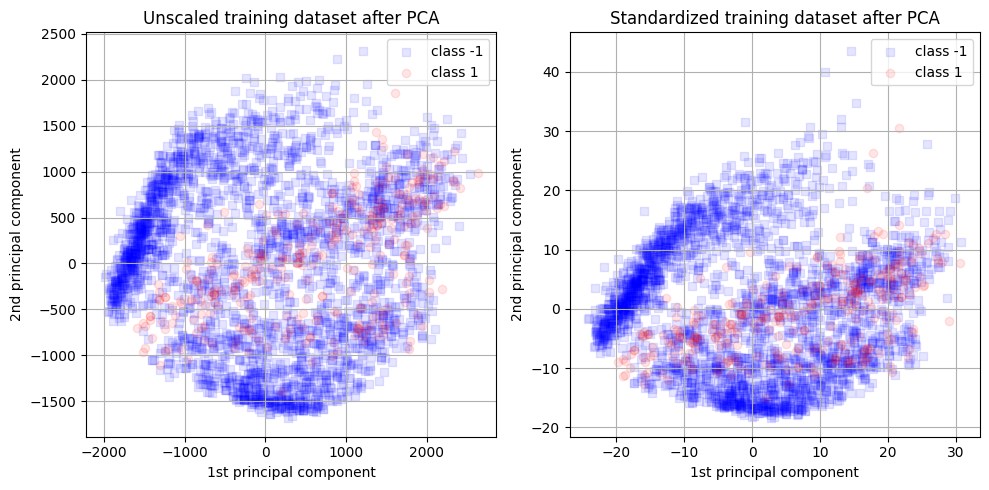

In [72]:
# this code is motivated from: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#effect-of-rescaling-on-a-pca-dimensional-reduction

# create a scatter plot side by side for the unscaled and scaled PCA
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = [-1, 1]
colors = (
    "blue",  # blue color for negative class
    "red",  # red color for positive class
)
markers = (
    "s",  # square marker for negative class
    "o",  # circle marker for positive class
)

for target_class, color, marker in zip(target_classes, colors, markers):
    # construct boolean mask for rows with the corresponding `target_class`
    target_class_mask = y_train == target_class

    # scatter plot for unscaled data
    ax1.scatter(
        x=X_train_transformed[target_class_mask, 0],  # first principal component
        y=X_train_transformed[target_class_mask, 1],  # second principal component
        color=color,
        label=f"class {target_class}",
        alpha=0.1,
        marker=marker,
    )

    # scatter plot for scaled data
    ax2.scatter(
        x=X_train_std_transformed[target_class_mask, 0],  # first principal component
        y=X_train_std_transformed[target_class_mask, 1],  # second principal component
        color=color,
        label=f"class {target_class}",
        alpha=0.1,
        marker=marker,
    )

ax1.set_title("Unscaled training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")

for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

_ = plt.tight_layout()

Key observations:

1. Applying dimensionality reduction on the raw images and reducing them from `784` to `2` causes huge loss of information. The explained variance of the data after applying PCA (for normal and scaled data) is less than 50%. Therefore, we can say that using only two components has a big disadventage on the information in the data.

2. Scaling the data (before performing PCA) produces less explained variance, and thus it's better not to scale the data.

3. From the scatter plots, we see that the data is not clearly separated. Meaning that points of the two classes are overlapping and don't exhibit some form of grouping (or clustering). Therefore, the resulting components won't be very much useful for solving the classification task. One reason for this happening is that the variance captured in these two components reflects change of color in images (black to white) rather than capturing more meaningful patterns.


## Reduce the number of dimensions of the training and test data together using PCA to 2 and plot a scatter plot of the training and test data showing examples of each set in a different colour (or marker style). What are your observations about the data based on this plot?


We repeat the previous steps but on the whole data (`X_train` and `X_test` combined).


In [73]:
# concatenate the two arrays
X_all = np.vstack((X_train, X_test))

In [74]:
# create a label array for the whole data
# first 3000 elements are from training data
# and last 3000 elements are from testing data
y_all = np.empty(X_all.shape[0], dtype="object")
y_all[:3000] = "train"
y_all[3000:] = "test"

In [75]:
print(f"Shape of X_all: {X_all.shape}")
print(f"Shape of y_all: {y_all.shape}")

Shape of X_all: (6000, 784)
Shape of y_all: (6000,)


In [76]:
scaler = StandardScaler()

In [77]:
scaled_X_all = scaler.fit_transform(X_all)

In [78]:
pca = PCA(n_components=2).fit(X_all)
scaled_pca = PCA(n_components=2).fit(scaled_X_all)

In [79]:
X_all_transformed = pca.transform(X_all)
X_all_std_transformed = scaled_pca.transform(scaled_X_all)

In [80]:
print(f"Normal PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(
    f"Total explained variance by two components on unscaled data: {sum(pca.explained_variance_ratio_)}"
)

print(f"Scaled PCA explained variance ratio: {scaled_pca.explained_variance_ratio_}")
print(
    f"Total explained variance by two components on scaled data: {sum(scaled_pca.explained_variance_ratio_)}"
)

Normal PCA explained variance ratio: [0.24058138 0.14245006]
Total explained variance by two components on unscaled data: 0.38303143076512813
Scaled PCA explained variance ratio: [0.18946732 0.11819337]
Total explained variance by two components on scaled data: 0.30766069437591254


Visualize the results of PCA in similar way as done previously:


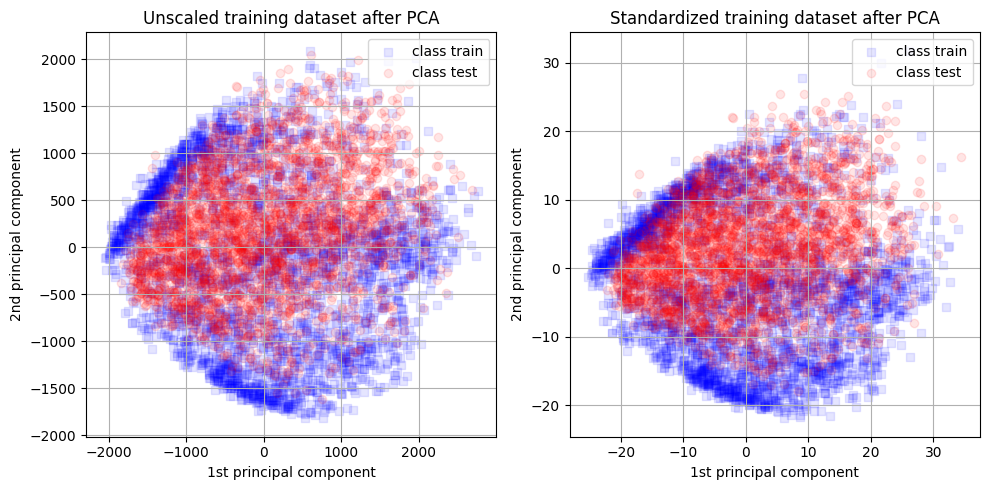

In [81]:
# create a scatter plot side by side for the unscaled and scaled PCA
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = ["train", "test"]
colors = (
    "blue",  # blue color for negative class
    "red",  # red color for positive class
)
markers = (
    "s",  # square marker for negative class
    "o",  # circle marker for positive class
)

for target_class, color, marker in zip(target_classes, colors, markers):
    # construct boolean mask for rows with the corresponding `target_class`
    target_class_mask = y_all == target_class

    # scatter plot for unscaled data
    ax1.scatter(
        x=X_all_transformed[target_class_mask, 0],  # first principal component
        y=X_all_transformed[target_class_mask, 1],  # second principal component
        color=color,
        label=f"class {target_class}",
        alpha=0.1,
        marker=marker,
    )

    # scatter plot for scaled data
    ax2.scatter(
        x=X_all_std_transformed[target_class_mask, 0],  # first principal component
        y=X_all_std_transformed[target_class_mask, 1],  # second principal component
        color=color,
        label=f"class {target_class}",
        alpha=0.1,
        marker=marker,
    )

ax1.set_title("Unscaled training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")

for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

_ = plt.tight_layout()

Key observations:

1. Similar to the previous experiment (with reducing dimensionality only for training data), we find that two components cause huge loss of information and that scaling worsen the results.

2. The data is not clearly separated into two groups. Most of the points are overlapping.


## Plot the scree graph of PCA and find the number of dimensions that explain 95% variance in the training set.


To plot the scree graph, we fit the PCA on the training data but without specifying the number of components.


In [82]:
pca = PCA().fit(X_train)

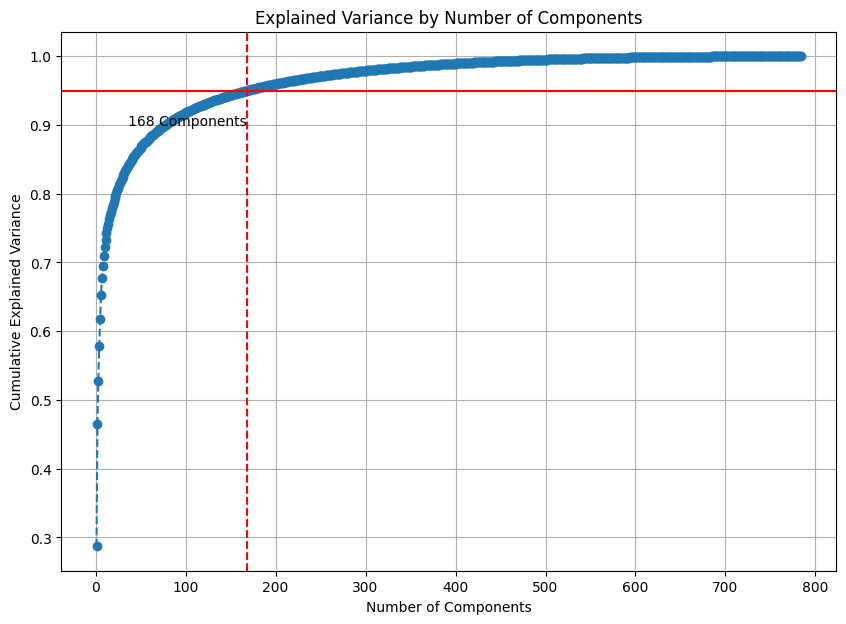

Number of components that explain 95% of variance: 168


In [83]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

num_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

plt.figure(figsize=(10, 7))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Explained Variance by Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="-")
plt.axvline(x=num_components_95, color="r", linestyle="--")
plt.text(num_components_95, 0.9, f"{num_components_95} Components", ha="right")
plt.grid(True)
plt.show()

print(f"Number of components that explain 95% of variance: {num_components_95}")

From the above plot, we find that we can explain 95% of the variance in the data by using `168` components.

Thus, we can keep only `168` features of the original `784` features and still reprsents the data quite good.


## Reduce the number of dimensions of the data using PCA and perform classification. You may want to select different principal components for the classification (not necessarily the first few). What is the (optimal) cross-validation performance of a Kernelized SVM classification with PCA? Remember to perform hyperparameter optimization!


In [84]:
class ComponentSelector(BaseEstimator, TransformerMixin):
    def __init__(self, components_to_skip=0):
        self.components_to_skip = components_to_skip

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_comp = X.shape[1]
        if self.components_to_skip > 0 and n_comp - self.components_to_skip > 0:
            return X[:, self.components_to_skip :]
        return X

In [85]:
pipeline = Pipeline(
    [
        ("pca", PCA()),
        (
            "component_selector",
            ComponentSelector(),
        ),
        ("svm", SVC(kernel="rbf")),
    ]
)

In [86]:
param_grid = {
    "pca__n_components": [5, 10, 15, 20, 30],
    "component_selector__components_to_skip": [
        0,
        5,
        10,
    ],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": [0.01, 0.1, 1, 10, 100],
}

In [87]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring={
        "accuracy": make_scorer(accuracy_score),
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "roc_auc": make_scorer(roc_auc_score, response_method="decision_function"),
        "pr_auc": make_scorer(auc_pr_score, response_method="decision_function"),
        "f1_score": make_scorer(f1_score),
        "matthews_correlation_coefficient": make_scorer(matthews_corrcoef),
    },
    refit=False,
    n_jobs=-1,
    verbose=1,
)

In [88]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('component_selector',
                                        ComponentSelector()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'component_selector__components_to_skip': [0, 5, 10],
                         'pca__n_components': [5, 10, 15, 20, 30],
                         'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': [0.01, 0.1, 1, 10, 100]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response...
                      'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                      'f1_score': make_scorer(f1_score, response_method='predict'),
                      'matthews_correlation_coefficient': make_scorer(matthews_corrcoef, response_method='predict'),
                      'pr_auc': make_scorer(auc_pr_score, response_method='decision_function'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='decision_function')},
             verbose=1)

In [89]:
pd.DataFrame(grid_search.cv_results_).loc[
    :,
    [
        "param_pca__n_components",
        "param_component_selector__components_to_skip",
        "param_svm__C",
        "param_svm__gamma",
        "mean_test_accuracy",
        "mean_test_balanced_accuracy",
        "mean_test_roc_auc",
        "mean_test_pr_auc",
        "mean_fit_time",
    ],
].sort_values(by=["mean_test_pr_auc", "mean_test_roc_auc"], ascending=False).head(5)

,param_pca__n_components,param_component_selector__components_to_skip,param_svm__C,param_svm__gamma,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_roc_auc,mean_test_pr_auc,mean_fit_time
126,10,5,1.0,0.10,0.901667,0.525730,0.544042,0.577946,0.815263
131,10,5,10.0,0.10,0.901667,0.525730,0.544042,0.577946,0.943339
136,10,5,100.0,0.10,0.901667,0.525730,0.544042,0.577946,0.922117
121,10,5,0.1,0.10,0.896333,0.500000,0.543687,0.577910,0.836566
265,20,10,1.0,0.01,0.900333,0.519278,0.542833,0.576539,0.938715


The above table shows the top 5 performing classifiers.

Using PCa with `n_components=10` and skipping first `5` principal componenets with `C=10` and `gamma=0.1` we get PR AUC score of 0.58.

This is clearly worse than previous performance achieved without using PCA (we got as close as 0.72).

However, the adventage of PCA here is the speed up it offers on the fit time.


# Question No. 5 Optimal Pipeline


So far, we have seen the performance of different classification algorithms `KNN`, `SVM` and `RandomForests`. We have also found that using `Normalizer` as pre-processing step delivers good results. And finally, we found that using dimensionality reduction `PCA` doesn't deliver good results but have the adventage of running faster.

To develop an _optimal_ pipeline, we will consider the following steps:

1. Pre-processing: As a first step, we will study the effect of applying different pre-processing methods. We will focus only on `Normalizer` and `StandardScaler` because we saw from previous experiments that they deliver good results.

2. Dimensionality reduction: For the second step, we will use `PCA` with differnet number of components. We saw earlier that using `168` components exaplin `95` of the variance of the data. Therefore, we will try the following different values for PCA: `[2, 10, 20, 100, 168]`. We will also try running the pipeline _without_ any dimensionality reduction.

3. Classification: The last step is to build a classifier on the pre-processed and reduced data. We saw from earlier how KNN, SVM, and Random Forests perform. Here we also need the hyperparameters of each classifier , including number of neighbors, kernel type, number of trees, and so on.

We will wrap these three steps in a `Pipeline` object and pass it to `GridSearchCV` to find the best performing parameters. As we have done earlier, we will define two separate (identical) objects for SVM alone and KNN and Random Forests. The reason for this is to ensure we are using either `.decision_function` or `.predict_proba`


## SVM pipeline


In [90]:
svm_pipeline = Pipeline(
    [
        ("preprocessor", StandardScaler()),
        ("reduction", PCA()),
        ("classifier", SVC(kernel="rbf")),
    ]
)

In [91]:
svm_param_grid = {
    "preprocessor": [
        StandardScaler(),
        Normalizer(),
    ],
    "reduction": [
        PCA(n_components=2),
        PCA(n_components=10),
        PCA(n_components=20),
        PCA(n_components=100),
        PCA(n_components=168),
        None,
    ],
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__gamma": [0.01, 0.1, 1, 10, 100],
}

In [92]:
# scoring function in SVM use the `decision_function` for calculating AUC metrics
svm_scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, response_method="decision_function"),
    "pr_auc": make_scorer(auc_pr_score, response_method="decision_function"),
}

In [93]:
# define a 5-fold cross validation grid search object for SVM
svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring=svm_scoring,
    n_jobs=-1,
    refit=False,
    verbose=1,
)

In [94]:
svm_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('reduction', PCA()),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__gamma': [0.01, 0.1, 1, 10, 100],
                         'preprocessor': [StandardScaler(), Normalizer()],
                         'reduction': [PCA(n_components=2),
                                       PCA(n_components=10),
                                       PCA(n_components=20),
                                       PCA(n_componen...
                                       PCA(n_components=168), None]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                      'pr_auc': make_scorer(auc_pr_score, response_method='decision_function'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='decision_function')},
             verbose=1)

In [95]:
pd.DataFrame(svm_grid_search.cv_results_)["mean_test_pr_auc"].max()

0.7241814136666344

## KNN/Random Forests Pipeline:


In [96]:
rf_knn_pipeline = Pipeline(
    [
        ("preprocessor", StandardScaler()),
        ("reduction", PCA()),
        ("classifier", RandomForestClassifier()),
    ]
)

In [97]:
rf_knn_param_grid = [
    {
        "preprocessor": [
            StandardScaler(),
            Normalizer(),
        ],
        "reduction": [
            PCA(n_components=2),
            PCA(n_components=10),
            PCA(n_components=20),
            PCA(n_components=100),
            PCA(n_components=168),
            None,
        ],
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [2, 5, 10],
    },
    {
        "preprocessor": [
            StandardScaler(),
            Normalizer(),
        ],
        "reduction": [
            PCA(n_components=2),
            PCA(n_components=10),
            PCA(n_components=20),
            PCA(n_components=100),
            PCA(n_components=168),
            None,
        ],
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_depth": [10, 20, None],
    },
]

In [98]:
# # scoring function in Random Forest and KNN use the `predict_proba` for calculating AUC metrics
rf_knn_scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, response_method="predict_proba"),
    "pr_auc": make_scorer(auc_pr_score, response_method="predict_proba"),
}

In [99]:
# define a 5-fold cross validation grid search object for Random Forests
rf_knn_grid_search = GridSearchCV(
    estimator=rf_knn_pipeline,
    param_grid=rf_knn_param_grid,
    cv=5,
    scoring=rf_knn_scoring,
    n_jobs=-1,
    refit=False,
    verbose=1,
)

In [100]:
rf_knn_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\Reslan Al Tinawi\Desktop\CS909-data-mining\assignment-1\cs909-assignment-1-venv\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('reduction', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [2, 5, 10],
                          'preprocessor': [StandardScaler(), Normalizer()],
                          'reduction': [PCA(n_components=2),
                                        PCA(n_components=10),
                                        PCA(n_compone...
                                        PCA(n_components=100),
                                        PCA(n_components=168), None]}],
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                      'pr_auc': make_scorer(auc_pr_score, response_method='predict_proba'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')},
             verbose=1)

In [101]:
pd.DataFrame(rf_knn_grid_search.cv_results_)["mean_test_pr_auc"].max()

0.7298965525195287

## Optimal pipeline:


In [102]:
svm_top_results = (
    pd.DataFrame(svm_grid_search.cv_results_)
    .sort_values(by="mean_test_pr_auc", ascending=False)[
        [
            "param_preprocessor",
            "param_reduction",
            "param_classifier__C",
            "param_classifier__gamma",
            "mean_test_accuracy",
            "mean_test_balanced_accuracy",
            "mean_test_roc_auc",
            "mean_test_pr_auc",
            "mean_fit_time",
        ]
    ]
    .head(1)
)

In [103]:
rf_top_results = (
    pd.DataFrame(rf_knn_grid_search.cv_results_)
    .sort_values(by="mean_test_pr_auc", ascending=False)[
        [
            "param_preprocessor",
            "param_reduction",
            "param_classifier",
            "param_classifier__n_estimators",
            "param_classifier__max_depth",
            "mean_test_accuracy",
            "mean_test_balanced_accuracy",
            "mean_test_roc_auc",
            "mean_test_pr_auc",
            "mean_fit_time",
        ]
    ]
    .head(1)
)

In [104]:
svm_top_results

,param_preprocessor,param_reduction,param_classifier__C,param_classifier__gamma,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_roc_auc,mean_test_pr_auc,mean_fit_time
106,Normalizer(),PCA(n_components=168),1.0,10.0,0.926333,0.67036,0.925957,0.724181,1.439013


In [105]:
rf_top_results

,param_preprocessor,param_reduction,param_classifier,param_classifier__n_estimators,param_classifier__max_depth,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_roc_auc,mean_test_pr_auc,mean_fit_time
107,Normalizer(),None,RandomForestClassifier(),200.0,20.0,0.924667,0.645326,0.941384,0.729897,9.121755


The results are somewhat similar. The random forest classifier achieves better ROC-AUC score.

The optimal pipeline will be:

1. Normalizer for pre-processing
2. No dimensionality reduction
3. Random Forests with 200 trees and 20 as max depth.


In [106]:
optimal_pipeline = Pipeline(
    [
        ("preprocessor", Normalizer()),
        ("classifier", RandomForestClassifier(n_estimators=200, max_depth=20)),
    ]
)

In [107]:
optimal_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Normalizer()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=200))])

In [108]:
y_pred_score = optimal_pipeline.predict_proba(X_test)

In [109]:
prediction_data = pd.DataFrame(data=y_pred_score[:, 1], columns=["y_score"])

In [110]:
prediction_data.head()

,y_score
0,0.420
1,0.230
2,0.230
3,0.125
4,0.305


In [111]:
prediction_data.to_csv("u2283791.csv", index=False)

# Question No. 6 Another classification problem


To re-build the data as explained in the question, we will create two arrays: `X_all` and `y_all`.

`X_all` is the result of (vertically) stacking `X_train` and `X_test` and `y_all` is an array filled with the labels `-1` for first _3000_ elements and `+1` for the second _3000_ elements.


In [112]:
# concatenate the two arrays
X_all = np.vstack((X_train, X_test))

# create a label array for the whole data
# first 3000 elements are from training data
# and last 3000 elements are from testing data
y_all = np.empty(X_all.shape[0], dtype=int)
y_all[:3000] = -1
y_all[3000:] = 1

In [113]:
skf = StratifiedKFold(n_splits=5)

In [114]:
optimal_pipeline

Pipeline(steps=[('preprocessor', Normalizer()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=200))])

In [115]:
# perform 5 folds cross validation on the *training* data and store the metrics in the `folds_results` list

folds_results = []

for fold, (train_index, test_index) in enumerate(skf.split(X_all, y_all)):
    # build the corresponding training and "validation" data
    X_train_fold, y_train_fold = X_all[train_index], y_all[train_index]
    X_test_fold, y_test_fold = X_all[test_index], y_all[test_index]

    # print label percentage for debugging
    print(f"Fold: {fold + 1}")
    print(
        f"Percentage of positive class in training data: {get_label_freq(y_train_fold, 1, True):.2f}"
    )
    print(
        f"Percentage of negative class in training data: {get_label_freq(y_train_fold, -1, True):.2f}"
    )

    print(
        f"Percentage of positive class in validation data: {get_label_freq(y_test_fold, 1, True):.2f}"
    )
    print(
        f"Percentage of negative class in validation data: {get_label_freq(y_test_fold, -1, True):.2f}"
    )

    print("==" * 30)

    # fit the classifier to the training data
    optimal_pipeline.fit(X_train_fold, y_train_fold)

    # get predictions on the validation data
    y_pred_fold = optimal_pipeline.predict(X_test_fold)

    # get prediction probabilities on the validation data
    # for calculating AUC-ROC and AUC-PR metrics
    y_pred_proba_fold = knn.predict_proba(X_test_fold)

    folds_results.append(
        {
            "fold": fold + 1,
            "accuracy": accuracy_score(y_test_fold, y_pred_fold),
            "balanced_accuracy": balanced_accuracy_score(y_test_fold, y_pred_fold),
            "roc_auc": roc_auc_score(y_test_fold, y_pred_proba_fold[:, 1]),
            "pr_auc": auc_pr_score(y_test_fold, y_pred_proba_fold[:, 1]),
            "f1_score": f1_score(y_test_fold, y_pred_fold),
            "matthews_correlation_coefficient": matthews_corrcoef(
                y_test_fold, y_pred_fold
            ),
        }
    )

Fold: 1
Percentage of positive class in training data: 0.50
Percentage of negative class in training data: 0.50
Percentage of positive class in validation data: 0.50
Percentage of negative class in validation data: 0.50
Fold: 2
Percentage of positive class in training data: 0.50
Percentage of negative class in training data: 0.50
Percentage of positive class in validation data: 0.50
Percentage of negative class in validation data: 0.50
Fold: 3
Percentage of positive class in training data: 0.50
Percentage of negative class in training data: 0.50
Percentage of positive class in validation data: 0.50
Percentage of negative class in validation data: 0.50
Fold: 4
Percentage of positive class in training data: 0.50
Percentage of negative class in training data: 0.50
Percentage of positive class in validation data: 0.50
Percentage of negative class in validation data: 0.50
Fold: 5
Percentage of positive class in training data: 0.50
Percentage of negative class in training data: 0.50
Percenta

In [116]:
metrics_df = pd.DataFrame(folds_results)

In [117]:
metrics_statistics_df = pd.DataFrame(
    data=[metrics_df.mean(), metrics_df.std()], index=["mean", "standard_deviation"]
).drop(columns=["fold"])

In [118]:
metrics_statistics_df

,accuracy,balanced_accuracy,roc_auc,pr_auc,f1_score,matthews_correlation_coefficient
mean,0.995333,0.995333,0.626770,0.621213,0.995366,0.990731
standard_deviation,0.003708,0.003708,0.012432,0.010865,0.003662,0.007325
